# Timeseries anomaly detection using an Autoencoder

## Objective

This script demonstrates how you can use a reconstruction autoencoder model to detect anomalies in timeseries data.


## Setup


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md

np.random.seed(42)
tf.random.set_seed(42)

2023-10-20 00:51:08.306123: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-20 00:51:08.671282: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-20 00:51:09.803900: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-20 00:51:09.803925: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-20 00:51:09.810505: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

## Load the data

We will use the [Numenta Anomaly Benchmark(NAB)](
https://www.kaggle.com/boltzmannbrain/nab) dataset. It provides artifical
timeseries data containing labeled anomalous periods of behavior. Data are
ordered, timestamped, single-valued metrics.

We will use the `art_daily_small_noise.csv` file for training and the
`art_daily_jumpsup.csv` file for testing. The simplicity of this dataset
allows us to demonstrate anomaly detection effectively.


In [2]:
df_small_noise = pd.read_csv('../../datasets/art_daily_small_noise.csv')
df_daily_jumpsup = pd.read_csv('../../datasets/art_daily_jumpsup.csv')

## Quick look at the data


In [3]:
print(df_small_noise.head())
print(df_daily_jumpsup.head())

             timestamp      value
0  2014-04-01 00:00:00  18.324919
1  2014-04-01 00:05:00  21.970327
2  2014-04-01 00:10:00  18.624806
3  2014-04-01 00:15:00  21.953684
4  2014-04-01 00:20:00  21.909120
             timestamp      value
0  2014-04-01 00:00:00  19.761252
1  2014-04-01 00:05:00  20.500833
2  2014-04-01 00:10:00  19.961641
3  2014-04-01 00:15:00  21.490266
4  2014-04-01 00:20:00  20.187739


## Visualize the data


In [4]:
def plot_dates_values(data):
    dates = data["timestamp"].to_list()
    values = data["value"].to_list()
    dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
    plt.subplots_adjust(bottom=0.2)
    plt.xticks(rotation=25)
    ax = plt.gca()
    xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
    ax.xaxis.set_major_formatter(xfmt)
    plt.plot(dates, values)
    plt.show()

### Timeseries data without anomalies

We will use the following data for training.


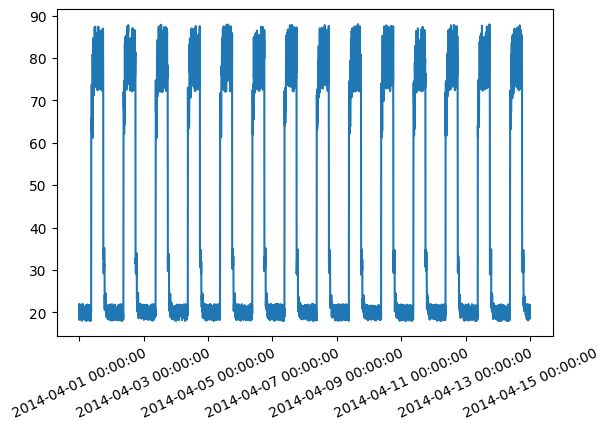

In [5]:
plot_dates_values(df_small_noise)

### Timeseries data with anomalies

We will use the following data for testing and see if the sudden jump up in the
data is detected as an anomaly.


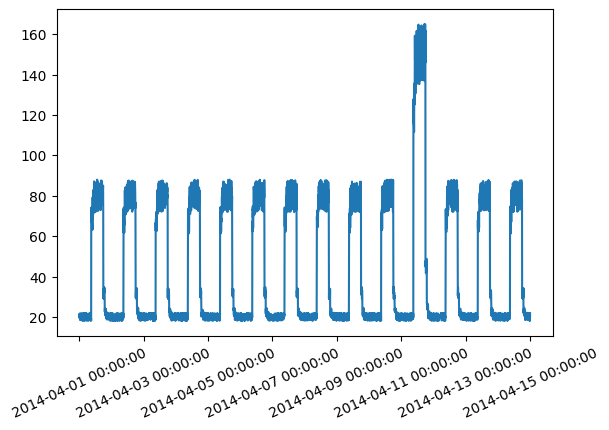

In [6]:
plot_dates_values(df_daily_jumpsup)

## Prepare training data

Get data values from the training timeseries data file and normalize the
`value` data. We have a `value` for every 5 mins for 14 days.

-   24 * 60 / 5 = **288 timesteps per day**
-   288 * 14 = **4032 data points** in total


In [7]:
def get_value_from_df(df):
    return df.value.to_list()


def normalize(values):
    mean = np.mean(values)
    values -= mean
    std = np.std(values)
    values /= std
    return values, mean, std


# Get the `value` column from the training dataframe.
training_value = get_value_from_df(df_small_noise)

# Normalize `value` and save the mean and std we get,
# for normalizing test data.
training_value, training_mean, training_std = normalize(training_value)
len(training_value)

4032

### Create sequences
Create sequences combining `TIME_STEPS` contiguous data values from the
training data.


In [8]:
TIME_STEPS = 288


def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    # Convert 2D sequences into 3D as we will be feeding this into
    # a convolutional layer.
    return np.expand_dims(output, axis=2)


x_train = create_sequences(training_value)
print("Training input shape: ", x_train.shape)


Training input shape:  (3744, 288, 1)


## Build a model

We will build a convolutional reconstruction autoencoder model. The model will
take input of shape `(batch_size, sequence_length, num_features)` and return
output of the same shape. In this case, `sequence_length` is 288 and
`num_features` is 1.


In [9]:
n_steps = x_train.shape[1]
n_features = x_train.shape[2]

keras.backend.clear_session()
model = keras.Sequential(
    [
        layers.Input(shape=(n_steps, n_features)),
        layers.Conv1D(filters=32, kernel_size=15, padding='same', data_format='channels_last', dilation_rate=1, activation="linear"),
        layers.LSTM(units=25, activation="tanh", name="lstm_1", return_sequences=False),
        layers.RepeatVector(n_steps),
        layers.LSTM(units=25, activation="tanh", name="lstm_2", return_sequences=True),
        layers.Conv1D(filters=32, kernel_size=15, padding='same', data_format='channels_last', dilation_rate=1, activation="linear"),
        layers.TimeDistributed(layers.Dense(1, activation='linear'))
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 288, 32)           512       
                                                                 
 lstm_1 (LSTM)               (None, 25)                5800      
                                                                 
 repeat_vector (RepeatVecto  (None, 288, 25)           0         
 r)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 288, 25)           5100      
                                                                 
 conv1d_1 (Conv1D)           (None, 288, 32)           12032     
                                                                 
 time_distributed (TimeDist  (None, 288, 1)            33        
 ributed)                                               

## Train the model

Please note that we are using `x_train` as both the input and the target
since this is a reconstruction model.


In [10]:
# initialize tqdm callback with default parameters
tqdm_callback = tfa.callbacks.TQDMProgressBar()

history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=256,
    validation_split=0.2,
    verbose=0,
    callbacks=[tqdm_callback,keras.callbacks.EarlyStopping(monitor="val_loss", patience=25, mode="min", restore_best_weights=True)],
)


/home/mantunes/git/aas/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Training:   0%|           0/50 ETA: ?s,  ?epochs/s

Epoch 1/50


14/14██████████ ETA: 00:00s - loss: 1.0002 - val_loss: 1.0066
Training:   2%|▏          1/50 ETA: 03:23s,   4.15s/epochs

Epoch 2/50


14/14██████████ ETA: 00:00s - loss: 0.9886 - val_loss: 0.9871
Training:   4%|▍          2/50 ETA: 02:16s,   2.84s/epochs

Epoch 3/50


14/14██████████ ETA: 00:00s - loss: 0.9547 - val_loss: 0.9580
Training:   6%|▌          3/50 ETA: 01:53s,   2.42s/epochs

Epoch 4/50


14/14██████████ ETA: 00:00s - loss: 0.9232 - val_loss: 0.9426
Training:   8%|▊          4/50 ETA: 01:42s,   2.22s/epochs

Epoch 5/50


14/14██████████ ETA: 00:00s - loss: 0.9076 - val_loss: 0.9318
Training:  10%|█          5/50 ETA: 01:34s,   2.10s/epochs

Epoch 6/50


14/14██████████ ETA: 00:00s - loss: 0.8947 - val_loss: 0.9217
Training:  12%|█▏         6/50 ETA: 01:29s,   2.04s/epochs

Epoch 7/50


14/14██████████ ETA: 00:00s - loss: 0.8884 - val_loss: 0.9124
Training:  14%|█▍         7/50 ETA: 01:26s,   2.01s/epochs

Epoch 8/50


14/14██████████ ETA: 00:00s - loss: 0.8715 - val_loss: 0.9012
Training:  16%|█▌         8/50 ETA: 01:23s,   1.99s/epochs

Epoch 9/50


14/14██████████ ETA: 00:00s - loss: 0.8964 - val_loss: 0.9194
Training:  18%|█▊         9/50 ETA: 01:18s,   1.93s/epochs

Epoch 10/50


14/14██████████ ETA: 00:00s - loss: 0.8844 - val_loss: 0.9092
Training:  20%|██         10/50 ETA: 01:14s,   1.87s/epochs

Epoch 11/50


14/14██████████ ETA: 00:00s - loss: 0.8733 - val_loss: 0.8996
Training:  22%|██▏        11/50 ETA: 01:11s,   1.83s/epochs

Epoch 12/50


14/14██████████ ETA: 00:00s - loss: 0.8579 - val_loss: 0.8836
Training:  24%|██▍        12/50 ETA: 01:08s,   1.81s/epochs

Epoch 13/50


14/14██████████ ETA: 00:00s - loss: 0.8527 - val_loss: 0.8793
Training:  26%|██▌        13/50 ETA: 01:06s,   1.80s/epochs

Epoch 14/50


14/14██████████ ETA: 00:00s - loss: 0.8454 - val_loss: 0.8723
Training:  28%|██▊        14/50 ETA: 01:04s,   1.79s/epochs

Epoch 15/50


14/14██████████ ETA: 00:00s - loss: 0.8619 - val_loss: 0.9049
Training:  30%|███        15/50 ETA: 01:02s,   1.78s/epochs

Epoch 16/50


14/14██████████ ETA: 00:00s - loss: 0.8785 - val_loss: 0.8952
Training:  32%|███▏       16/50 ETA: 00:59s,   1.76s/epochs

Epoch 17/50


14/14██████████ ETA: 00:00s - loss: 0.8597 - val_loss: 0.8830
Training:  34%|███▍       17/50 ETA: 00:57s,   1.76s/epochs

Epoch 18/50


14/14██████████ ETA: 00:00s - loss: 0.8498 - val_loss: 0.8788
Training:  36%|███▌       18/50 ETA: 00:56s,   1.76s/epochs

Epoch 19/50


14/14██████████ ETA: 00:00s - loss: 0.8570 - val_loss: 0.8578
Training:  38%|███▊       19/50 ETA: 00:55s,   1.78s/epochs

Epoch 20/50


14/14██████████ ETA: 00:00s - loss: 0.8400 - val_loss: 0.8404
Training:  40%|████       20/50 ETA: 00:53s,   1.78s/epochs

Epoch 21/50


14/14██████████ ETA: 00:00s - loss: 0.8442 - val_loss: 0.8608
Training:  42%|████▏      21/50 ETA: 00:51s,   1.78s/epochs

Epoch 22/50


14/14██████████ ETA: 00:00s - loss: 0.8344 - val_loss: 0.8973
Training:  44%|████▍      22/50 ETA: 00:49s,   1.78s/epochs

Epoch 23/50


14/14██████████ ETA: 00:00s - loss: 0.8553 - val_loss: 0.8664
Training:  46%|████▌      23/50 ETA: 00:47s,   1.77s/epochs

Epoch 24/50


14/14██████████ ETA: 00:00s - loss: 0.8317 - val_loss: 0.8563
Training:  48%|████▊      24/50 ETA: 00:46s,   1.79s/epochs

Epoch 25/50


14/14██████████ ETA: 00:00s - loss: 0.8242 - val_loss: 0.8784
Training:  50%|█████      25/50 ETA: 00:45s,   1.81s/epochs

Epoch 26/50


14/14██████████ ETA: 00:00s - loss: 0.8886 - val_loss: 0.8837
Training:  52%|█████▏     26/50 ETA: 00:44s,   1.83s/epochs

Epoch 27/50


14/14██████████ ETA: 00:00s - loss: 0.8677 - val_loss: 0.8749
Training:  54%|█████▍     27/50 ETA: 00:43s,   1.87s/epochs

Epoch 28/50


14/14██████████ ETA: 00:00s - loss: 0.8481 - val_loss: 0.8668
Training:  56%|█████▌     28/50 ETA: 00:41s,   1.89s/epochs

Epoch 29/50


14/14██████████ ETA: 00:00s - loss: 0.8563 - val_loss: 0.8604
Training:  58%|█████▊     29/50 ETA: 00:39s,   1.88s/epochs

Epoch 30/50


14/14██████████ ETA: 00:00s - loss: 0.8270 - val_loss: 0.8380
Training:  60%|██████     30/50 ETA: 00:37s,   1.88s/epochs

Epoch 31/50


14/14██████████ ETA: 00:00s - loss: 0.8184 - val_loss: 0.8573
Training:  62%|██████▏    31/50 ETA: 00:35s,   1.88s/epochs

Epoch 32/50


14/14██████████ ETA: 00:00s - loss: 0.8187 - val_loss: 0.8212
Training:  64%|██████▍    32/50 ETA: 00:33s,   1.84s/epochs

Epoch 33/50


14/14██████████ ETA: 00:00s - loss: 0.8028 - val_loss: 0.8308
Training:  66%|██████▌    33/50 ETA: 00:30s,   1.80s/epochs

Epoch 34/50


14/14██████████ ETA: 00:00s - loss: 0.7877 - val_loss: 0.7738
Training:  68%|██████▊    34/50 ETA: 00:28s,   1.81s/epochs

Epoch 35/50


14/14██████████ ETA: 00:00s - loss: 0.7719 - val_loss: 0.7890
Training:  70%|███████    35/50 ETA: 00:26s,   1.80s/epochs

Epoch 36/50


14/14██████████ ETA: 00:00s - loss: 0.8682 - val_loss: 0.8780
Training:  72%|███████▏   36/50 ETA: 00:24s,   1.78s/epochs

Epoch 37/50


14/14██████████ ETA: 00:00s - loss: 0.8336 - val_loss: 0.8613
Training:  74%|███████▍   37/50 ETA: 00:23s,   1.81s/epochs

Epoch 38/50


14/14██████████ ETA: 00:00s - loss: 0.8161 - val_loss: 0.8412
Training:  76%|███████▌   38/50 ETA: 00:21s,   1.80s/epochs

Epoch 39/50


14/14██████████ ETA: 00:00s - loss: 0.8046 - val_loss: 0.8271
Training:  78%|███████▊   39/50 ETA: 00:19s,   1.80s/epochs

Epoch 40/50


14/14██████████ ETA: 00:00s - loss: 0.7942 - val_loss: 0.8156
Training:  80%|████████   40/50 ETA: 00:17s,   1.79s/epochs

Epoch 41/50


14/14██████████ ETA: 00:00s - loss: 0.7849 - val_loss: 0.8028
Training:  82%|████████▏  41/50 ETA: 00:16s,   1.81s/epochs

Epoch 42/50


14/14██████████ ETA: 00:00s - loss: 0.7832 - val_loss: 0.8097
Training:  84%|████████▍  42/50 ETA: 00:14s,   1.77s/epochs

Epoch 43/50


14/14██████████ ETA: 00:00s - loss: 0.7984 - val_loss: 0.8039
Training:  86%|████████▌  43/50 ETA: 00:12s,   1.75s/epochs

Epoch 44/50


14/14██████████ ETA: 00:00s - loss: 0.7769 - val_loss: 0.8305
Training:  88%|████████▊  44/50 ETA: 00:10s,   1.76s/epochs

Epoch 45/50


14/14██████████ ETA: 00:00s - loss: 0.7799 - val_loss: 0.7778
Training:  90%|█████████  45/50 ETA: 00:08s,   1.74s/epochs

Epoch 46/50


14/14██████████ ETA: 00:00s - loss: 0.7724 - val_loss: 0.7904
Training:  92%|█████████▏ 46/50 ETA: 00:06s,   1.72s/epochs

Epoch 47/50


14/14██████████ ETA: 00:00s - loss: 0.7614 - val_loss: 0.7701
Training:  94%|█████████▍ 47/50 ETA: 00:05s,   1.73s/epochs

Epoch 48/50


14/14██████████ ETA: 00:00s - loss: 0.7547 - val_loss: 0.7515
Training:  96%|█████████▌ 48/50 ETA: 00:03s,   1.73s/epochs

Epoch 49/50


14/14██████████ ETA: 00:00s - loss: 0.7581 - val_loss: 0.8076
Training:  98%|█████████▊ 49/50 ETA: 00:01s,   1.74s/epochs

Epoch 50/50


14/14██████████ ETA: 00:00s - loss: 0.7855 - val_loss: 0.7710
Training: 100%|██████████ 50/50 ETA: 00:00s,   1.85s/epochs


Let's plot training and validation loss to see how the training went.


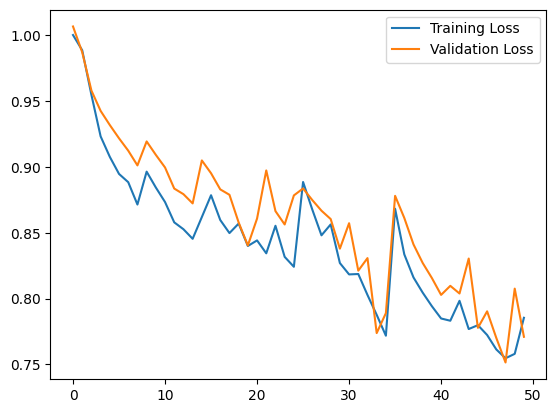

In [11]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

## Detecting anomalies

We will detect anomalies by determining how well our model can reconstruct
the input data.


1.   Find MAE loss on training samples.
2.   Find max MAE loss value. This is the worst our model has performed trying
to reconstruct a sample. We will make this the `threshold` for anomaly
detection.
3.   If the reconstruction loss for a sample is greater than this `threshold`
value then we can infer that the model is seeing a pattern that it isn't
familiar with. We will label this sample as an `anomaly`.



117/117 [==============================] - 2s 16ms/step


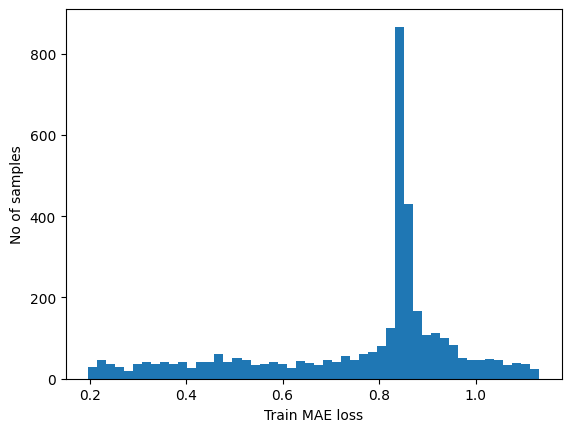

Reconstruction error threshold:  1.131831529779513


In [12]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)


### Compare recontruction

Just for fun, let's see how our model has recontructed the first sample.
This is the 288 timesteps from day 1 of our training dataset.


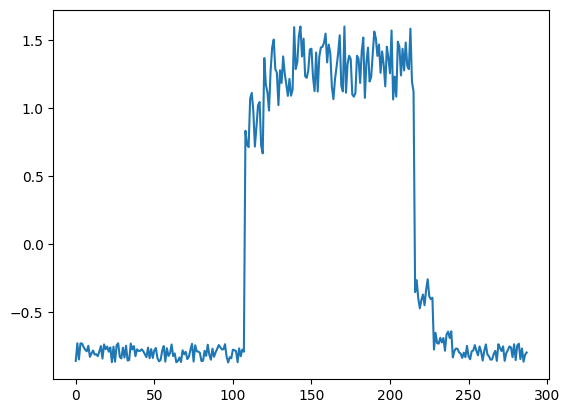

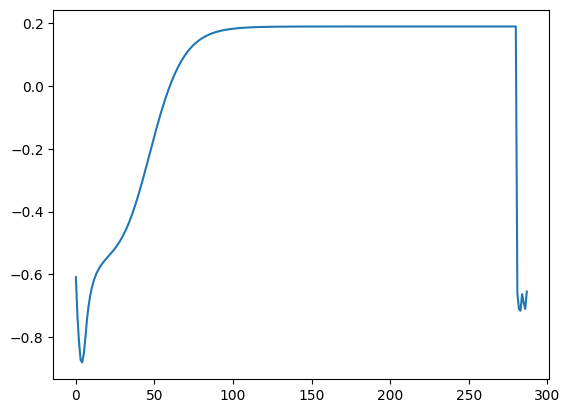

In [13]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.show()
plt.plot(x_train_pred[0])
plt.show()


### Prepare test data


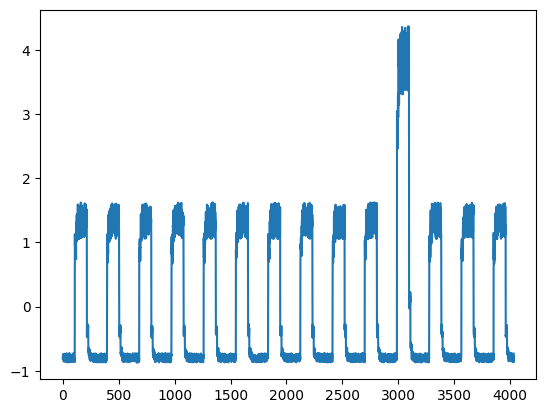

Test input shape:  (3744, 288, 1)
117/117 [==============================] - 2s 15ms/step


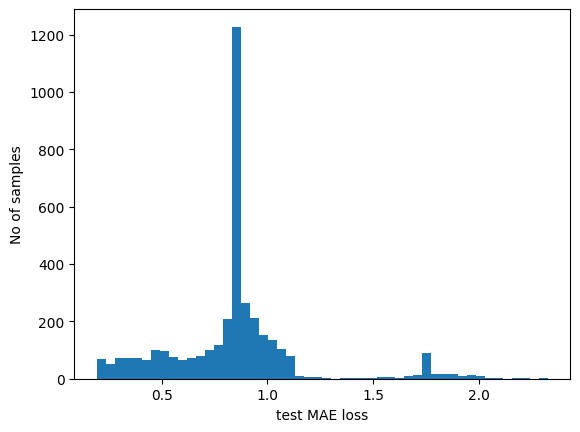

Number of anomaly samples:  251
Indices of anomaly samples:  (array([ 972, 1548, 2123, 2124, 2699, 2700, 2703, 2704, 2705, 2706, 2708,
       2750, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763,
       2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774,
       2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785,
       2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796,
       2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807,
       2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818,
       2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829,
       2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840,
       2841, 2842, 2843, 2844, 2845, 2846, 2847, 2848, 2849, 2850, 2851,
       2852, 2853, 2854, 2855, 2856, 2857, 2858, 2859, 2860, 2861, 2862,
       2863, 2864, 2865, 2866, 2867, 2868, 2869, 2870, 2871, 2872, 2873,
       2874, 2875, 2876, 2877, 2878, 2879, 2880, 2881, 2882, 2

In [14]:

def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values


test_value = get_value_from_df(df_daily_jumpsup)
test_value = normalize_test(test_value, training_mean, training_std)
plt.plot(test_value.tolist())
plt.show()

# Create sequences from test values.
x_test = create_sequences(test_value)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))


## Plot anomalies

We now know the samples of the data which are anomalies. With this, we will
find the corresponding `timestamps` from the original test data. We will be
using the following method to do that:

Let's say time_steps = 3 and we have 10 training values. Our `x_train` will
look like this:

- 0, 1, 2
- 1, 2, 3
- 2, 3, 4
- 3, 4, 5
- 4, 5, 6
- 5, 6, 7
- 6, 7, 8
- 7, 8, 9

All except the initial and the final time_steps-1 data values, will appear in
`time_steps` number of samples. So, if we know that the samples
[(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can say that the data point
5 is an anomaly.


In [15]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(test_value) - TIME_STEPS + 1):
    time_series = range(data_idx - TIME_STEPS + 1, data_idx)
    if all([anomalies[j] for j in time_series]):
        anomalous_data_indices.append(data_idx)


Let's overlay the anomalies on the original test data plot.


[]


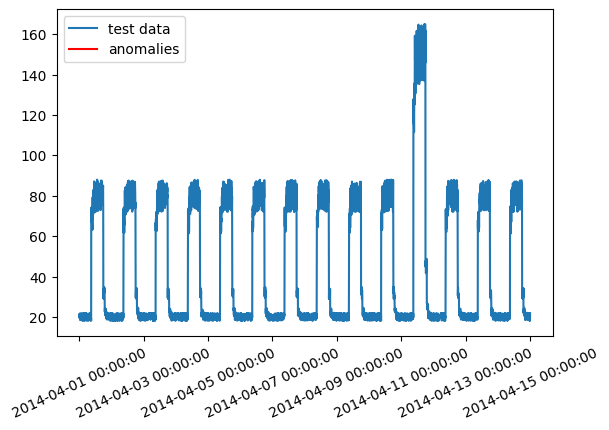

In [17]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices, :]
plt.subplots_adjust(bottom=0.2)
plt.xticks(rotation=25)
ax = plt.gca()
xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
ax.xaxis.set_major_formatter(xfmt)

dates = df_daily_jumpsup["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = df_daily_jumpsup["value"].to_list()
plt.plot(dates, values, label="test data")

dates = df_subset["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = df_subset["value"].to_list()

print(f'{values}')

plt.plot(dates, values, label="anomalies", color="r")

plt.legend()
plt.show()